In [73]:
import pandas as pd
from sklearn.model_selection import train_test_split


In [74]:
features_df = pd.read_parquet("data/contribution_data/extracted_features.parquet")

In [75]:
features_df.head()

,user_id,user_edit_frequency,editor_used,area_delta,length_delta,area,length,bounding_box_size,geometry_valid,xmax,...,emergency,geological,healthcare,highway,historic,landuse,leisure,man_made,military,vandalism
0,2377515,32.000000,iD 1.5.4,-597,0,0,0,1.180083e-05,0,-62.976084,...,0,0,0,0,0,0,0,0,0,True
1,2377515,32.000000,iD 1.5.4,-661,0,0,0,1.543374e-05,0,-62.956141,...,0,0,0,0,0,0,0,0,0,True
2,6335199,5.490196,iD 2.5.1,-6351,0,0,0,7.911717e-06,0,-90.207543,...,0,0,0,0,0,1,0,0,0,True
3,5193146,3.762032,JOSM,-60560,0,0,0,3.357874e-05,0,-0.898112,...,0,0,0,0,0,0,1,0,0,True
4,3149129,3791.000000,JOSM,-47,0,0,0,5.833380e-09,0,-34.881410,...,0,0,0,0,0,0,0,0,0,True


In [76]:
if features_df.columns.__contains__('xzcode'):
    # Split 'xzcode' column into two separate columns 'code' and 'level'
    features_df[['code', 'level']] = pd.json_normalize(features_df['xzcode'])
    features_df.drop('xzcode', axis=1, inplace=True)
features_df.head()

,user_id,user_edit_frequency,editor_used,area_delta,length_delta,area,length,bounding_box_size,geometry_valid,xmax,...,healthcare,highway,historic,landuse,leisure,man_made,military,vandalism,code,level
0,2377515,32.000000,iD 1.5.4,-597,0,0,0,1.180083e-05,0,-62.976084,...,0,0,0,0,0,0,0,True,384395826,14
1,2377515,32.000000,iD 1.5.4,-661,0,0,0,1.543374e-05,0,-62.956141,...,0,0,0,0,0,0,0,True,384395847,14
2,6335199,5.490196,iD 2.5.1,-6351,0,0,0,7.911717e-06,0,-90.207543,...,0,0,0,1,0,0,0,True,3209861041,15
3,5193146,3.762032,JOSM,-60560,0,0,0,3.357874e-05,0,-0.898112,...,0,0,0,0,1,0,0,True,3576265364,15
4,3149129,3791.000000,JOSM,-47,0,0,0,5.833380e-09,0,-34.881410,...,0,0,0,0,0,0,0,True,1391593370,16


In [77]:
features_df.members.unique()

array([None], dtype=object)

In [78]:
if features_df.columns.__contains__('geometry'):
    features_df.drop('geometry', axis=1, inplace=True)
    
if features_df.columns.__contains__('osm_id'):
    features_df.drop('osm_id', axis=1, inplace=True)
    
    
if features_df.columns.__contains__('members'):
    features_df.drop('members', axis=1, inplace=True)
    
features_df.head()

,user_id,user_edit_frequency,editor_used,area_delta,length_delta,area,length,bounding_box_size,geometry_valid,xmax,...,healthcare,highway,historic,landuse,leisure,man_made,military,vandalism,code,level
0,2377515,32.000000,iD 1.5.4,-597,0,0,0,1.180083e-05,0,-62.976084,...,0,0,0,0,0,0,0,True,384395826,14
1,2377515,32.000000,iD 1.5.4,-661,0,0,0,1.543374e-05,0,-62.956141,...,0,0,0,0,0,0,0,True,384395847,14
2,6335199,5.490196,iD 2.5.1,-6351,0,0,0,7.911717e-06,0,-90.207543,...,0,0,0,1,0,0,0,True,3209861041,15
3,5193146,3.762032,JOSM,-60560,0,0,0,3.357874e-05,0,-0.898112,...,0,0,0,0,1,0,0,True,3576265364,15
4,3149129,3791.000000,JOSM,-47,0,0,0,5.833380e-09,0,-34.881410,...,0,0,0,0,0,0,0,True,1391593370,16


In [79]:
features_df.columns = features_df.columns.str.replace(' ', '_', regex=True)
features_df.head()

,user_id,user_edit_frequency,editor_used,area_delta,length_delta,area,length,bounding_box_size,geometry_valid,xmax,...,healthcare,highway,historic,landuse,leisure,man_made,military,vandalism,code,level
0,2377515,32.000000,iD 1.5.4,-597,0,0,0,1.180083e-05,0,-62.976084,...,0,0,0,0,0,0,0,True,384395826,14
1,2377515,32.000000,iD 1.5.4,-661,0,0,0,1.543374e-05,0,-62.956141,...,0,0,0,0,0,0,0,True,384395847,14
2,6335199,5.490196,iD 2.5.1,-6351,0,0,0,7.911717e-06,0,-90.207543,...,0,0,0,1,0,0,0,True,3209861041,15
3,5193146,3.762032,JOSM,-60560,0,0,0,3.357874e-05,0,-0.898112,...,0,0,0,0,1,0,0,True,3576265364,15
4,3149129,3791.000000,JOSM,-47,0,0,0,5.833380e-09,0,-34.881410,...,0,0,0,0,0,0,0,True,1391593370,16


In [80]:
X = features_df.drop('vandalism', axis=1).copy()
X.head()

,user_id,user_edit_frequency,editor_used,area_delta,length_delta,area,length,bounding_box_size,geometry_valid,xmax,...,geological,healthcare,highway,historic,landuse,leisure,man_made,military,code,level
0,2377515,32.000000,iD 1.5.4,-597,0,0,0,1.180083e-05,0,-62.976084,...,0,0,0,0,0,0,0,0,384395826,14
1,2377515,32.000000,iD 1.5.4,-661,0,0,0,1.543374e-05,0,-62.956141,...,0,0,0,0,0,0,0,0,384395847,14
2,6335199,5.490196,iD 2.5.1,-6351,0,0,0,7.911717e-06,0,-90.207543,...,0,0,0,0,1,0,0,0,3209861041,15
3,5193146,3.762032,JOSM,-60560,0,0,0,3.357874e-05,0,-0.898112,...,0,0,0,0,0,1,0,0,3576265364,15
4,3149129,3791.000000,JOSM,-47,0,0,0,5.833380e-09,0,-34.881410,...,0,0,0,0,0,0,0,0,1391593370,16


In [81]:
y = features_df['vandalism'].copy()
y.head()

0    True
1    True
2    True
3    True
4    True
Name: vandalism, dtype: bool

In [82]:
X_encoded = pd.get_dummies(X, columns=['source_reliability',
                                       'historical_validity',
                                       'country_count',
                                       'population_changed',
                                       'boundary_changed',
                                       'name_changed',
                                       'tags_modified',
                                       'tags_added',
                                       'tags_removed',
                                       'edit_time_of_day',
                                       'geometry_valid',
                                       'editor_used',
                                       'osm_type',
                                       'contribution_type',
                                       'status'])
X_encoded.head()

,user_id,user_edit_frequency,area_delta,length_delta,area,length,bounding_box_size,xmax,xmin,ymax,...,osm_type_way,contribution_type_CREATED,contribution_type_DELETED,contribution_type_GEOMETRY,contribution_type_NONE,contribution_type_TAG,contribution_type_TAG_GEOMETRY,status_deleted,status_history,status_latest
0,2377515,32.000000,-597,0,0,0,1.180083e-05,-62.976084,-62.996941,-84.906087,...,True,False,True,False,False,False,False,True,False,False
1,2377515,32.000000,-661,0,0,0,1.543374e-05,-62.956141,-62.975782,-84.905873,...,True,False,True,False,False,False,False,True,False,False
2,6335199,5.490196,-6351,0,0,0,7.911717e-06,-90.207543,-90.209129,38.525163,...,True,False,True,False,False,False,False,True,False,False
3,5193146,3.762032,-60560,0,0,0,3.357874e-05,-0.898112,-0.907923,41.659127,...,True,False,True,False,False,False,False,True,False,False
4,3149129,3791.000000,-47,0,0,0,5.833380e-09,-34.881410,-34.881507,-8.043102,...,True,False,True,False,False,False,False,True,False,False


In [108]:
assert X_encoded.dtypes.__contains__('object') == False

In [106]:
y = y.replace(True, 1)
y = y.replace(False, 0)

In [85]:
y.dtype

dtype('int64')

In [86]:
sum(y) / len(y)

0.6621638875411762

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state=42, stratify=y)

In [88]:
# Get the shapes of the datasets
shapes = {
    'X_train shape': X_train.shape,
    'X_test shape': X_test.shape,
    'y_train shape': y_train.shape,
    'y_test shape': y_test.shape
}

# Convert shapes to DataFrame for better display
shapes_df = pd.DataFrame(shapes, index=['Number of Samples', 'Number of Features']).T
print(shapes_df)

               Number of Samples  Number of Features
X_train shape             352449                 586
X_test shape              117483                 586
y_train shape             352449              352449
y_test shape              117483              117483


In [89]:
sum(y_train)/len(y_train)

0.6621638875411762

In [90]:
sum(y_test)/len(y_test)

0.6621638875411762

In [113]:
# Cross Validation
import xgboost as xgb
import numpy as np

# Set up the parameters (you can use your existing ones)
params = {
    'objective': 'binary:logistic',  # Binary classification
    'eval_metric': ['aucpr', 'error'],  # Evaluation metrics
    'seed': 42
}

# Number of boosting rounds
num_boost_round = 100

# Number of folds
n_folds = 5

# Perform 5-fold cross-validation
cv_results = xgb.cv(
    params,
    xgb.DMatrix(X_train, label=y_train),
    num_boost_round=num_boost_round,
    nfold=n_folds,
    early_stopping_rounds=15,
    metrics=['aucpr', 'error'],  # Use AUC-PR and error for validation
    seed=42,
    verbose_eval=True
)

# Display cross-validation results
cv_results


[0]	train-aucpr:0.95493+0.00117	train-error:0.21000+0.00624	test-aucpr:0.95454+0.00102	test-error:0.21039+0.00649
[1]	train-aucpr:0.97242+0.00156	train-error:0.13956+0.00643	test-aucpr:0.97218+0.00130	test-error:0.14048+0.00633
[2]	train-aucpr:0.97935+0.00228	train-error:0.11643+0.00534	test-aucpr:0.97916+0.00223	test-error:0.11713+0.00553
[3]	train-aucpr:0.98066+0.00228	train-error:0.11121+0.00691	test-aucpr:0.98043+0.00226	test-error:0.11207+0.00647
[4]	train-aucpr:0.98330+0.00145	train-error:0.09848+0.00494	test-aucpr:0.98311+0.00140	test-error:0.09906+0.00475
[5]	train-aucpr:0.98493+0.00124	train-error:0.09310+0.00486	test-aucpr:0.98477+0.00109	test-error:0.09390+0.00459
[6]	train-aucpr:0.98617+0.00115	train-error:0.08781+0.00474	test-aucpr:0.98596+0.00110	test-error:0.08889+0.00432
[7]	train-aucpr:0.98715+0.00075	train-error:0.08399+0.00281	test-aucpr:0.98693+0.00065	test-error:0.08513+0.00248
[8]	train-aucpr:0.98751+0.00066	train-error:0.08272+0.00263	test-aucpr:0.98730+0.00059	t

,train-aucpr-mean,train-aucpr-std,train-error-mean,train-error-std,test-aucpr-mean,test-aucpr-std,test-error-mean,test-error-std
0,0.954929,0.001169,0.210001,0.006240,0.954544,0.001017,0.210388,0.006490
1,0.972422,0.001564,0.139563,0.006433,0.972182,0.001300,0.140477,0.006335
2,0.979352,0.002279,0.116433,0.005338,0.979162,0.002233,0.117132,0.005526
3,0.980659,0.002282,0.111215,0.006911,0.980434,0.002264,0.112067,0.006472
4,0.983296,0.001445,0.098479,0.004941,0.983108,0.001404,0.099055,0.004751
...,...,...,...,...,...,...,...,...
95,0.999287,0.000026,0.015660,0.000398,0.999090,0.000064,0.017486,0.000592
96,0.999304,0.000033,0.015440,0.000438,0.999110,0.000070,0.017319,0.000738
97,0.999320,0.000034,0.015165,0.000500,0.999127,0.000072,0.017035,0.000822
98,0.999332,0.000038,0.015031,0.000649,0.999142,0.000074,0.016916,0.000998



Best Results (Final Round):
    train-aucpr-mean  train-aucpr-std  train-error-mean  train-error-std  \
99          0.999354         0.000045          0.014767         0.000768   

    test-aucpr-mean  test-aucpr-std  test-error-mean  test-error-std  
99         0.999162        0.000071         0.016675        0.001058  


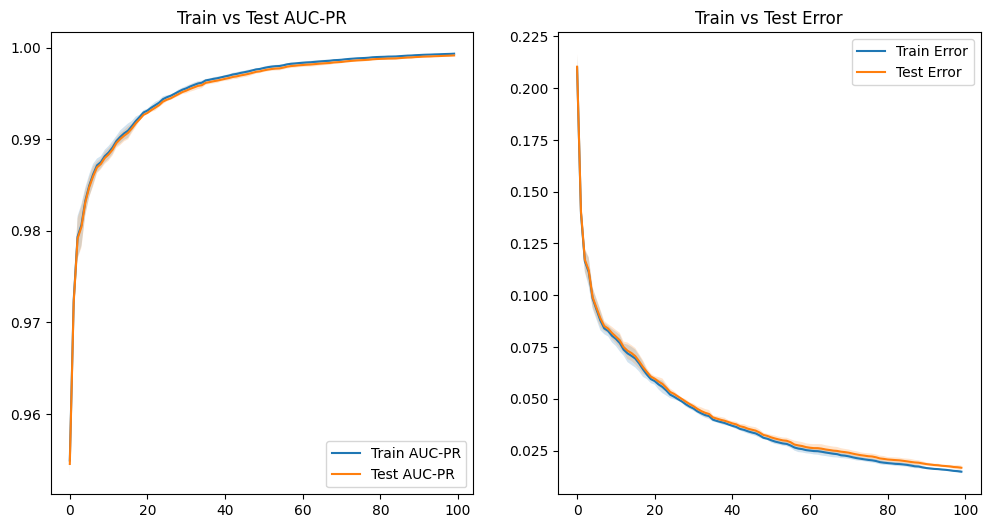

In [114]:
# Display the last row to show the best results
print("\nBest Results (Final Round):")
print(cv_results.tail(1))

# Plot the learning curves for both AUC-PR and error
import matplotlib.pyplot as plt

# Plot AUC-PR
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(cv_results['train-aucpr-mean'], label='Train AUC-PR')
plt.plot(cv_results['test-aucpr-mean'], label='Test AUC-PR')
plt.fill_between(range(len(cv_results)), 
                 cv_results['train-aucpr-mean'] - cv_results['train-aucpr-std'], 
                 cv_results['train-aucpr-mean'] + cv_results['train-aucpr-std'], 
                 alpha=0.2)
plt.fill_between(range(len(cv_results)), 
                 cv_results['test-aucpr-mean'] - cv_results['test-aucpr-std'], 
                 cv_results['test-aucpr-mean'] + cv_results['test-aucpr-std'], 
                 alpha=0.2)
plt.title('Train vs Test AUC-PR')
plt.legend()

# Plot Error
plt.subplot(1, 2, 2)
plt.plot(cv_results['train-error-mean'], label='Train Error')
plt.plot(cv_results['test-error-mean'], label='Test Error')
plt.fill_between(range(len(cv_results)), 
                 cv_results['train-error-mean'] - cv_results['train-error-std'], 
                 cv_results['train-error-mean'] + cv_results['train-error-std'], 
                 alpha=0.2)
plt.fill_between(range(len(cv_results)), 
                 cv_results['test-error-mean'] - cv_results['test-error-std'], 
                 cv_results['test-error-mean'] + cv_results['test-error-std'], 
                 alpha=0.2)
plt.title('Train vs Test Error')
plt.legend()

plt.show()


In [109]:
import xgboost as xgb
import matplotlib.pyplot as plt

# Convert the datasets to DMatrix format
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Specify model parameters with both 'aucpr' and 'error'
params = {
    'objective': 'binary:logistic',  # Binary classification
    'eval_metric': ['aucpr', 'error'],  # 'error' is 1 - accuracy
    'seed': 42
}

# Set up the evaluation set with both training and test sets
evals = [(dtrain, 'train'), (dtest, 'eval')]

# Dictionary to store evaluation results
evals_result = {}

# Train the model with early stopping and store the results
bst = xgb.train(params, dtrain, num_boost_round=100, evals=evals, 
                early_stopping_rounds=15, evals_result=evals_result, 
                verbose_eval=True)


[0]	train-aucpr:0.95557	train-error:0.20095	eval-aucpr:0.95554	eval-error:0.20160
[1]	train-aucpr:0.97054	train-error:0.14711	eval-aucpr:0.97030	eval-error:0.14794
[2]	train-aucpr:0.98143	train-error:0.11078	eval-aucpr:0.98102	eval-error:0.11248
[3]	train-aucpr:0.98332	train-error:0.10288	eval-aucpr:0.98296	eval-error:0.10394
[4]	train-aucpr:0.98435	train-error:0.09639	eval-aucpr:0.98398	eval-error:0.09724
[5]	train-aucpr:0.98638	train-error:0.08887	eval-aucpr:0.98606	eval-error:0.09063
[6]	train-aucpr:0.98739	train-error:0.08220	eval-aucpr:0.98706	eval-error:0.08387
[7]	train-aucpr:0.98816	train-error:0.07885	eval-aucpr:0.98784	eval-error:0.08079
[8]	train-aucpr:0.98856	train-error:0.07991	eval-aucpr:0.98825	eval-error:0.08155
[9]	train-aucpr:0.98889	train-error:0.07857	eval-aucpr:0.98858	eval-error:0.08024
[10]	train-aucpr:0.98911	train-error:0.07698	eval-aucpr:0.98878	eval-error:0.07852
[11]	train-aucpr:0.99073	train-error:0.06938	eval-aucpr:0.99047	eval-error:0.07053
[12]	train-auc

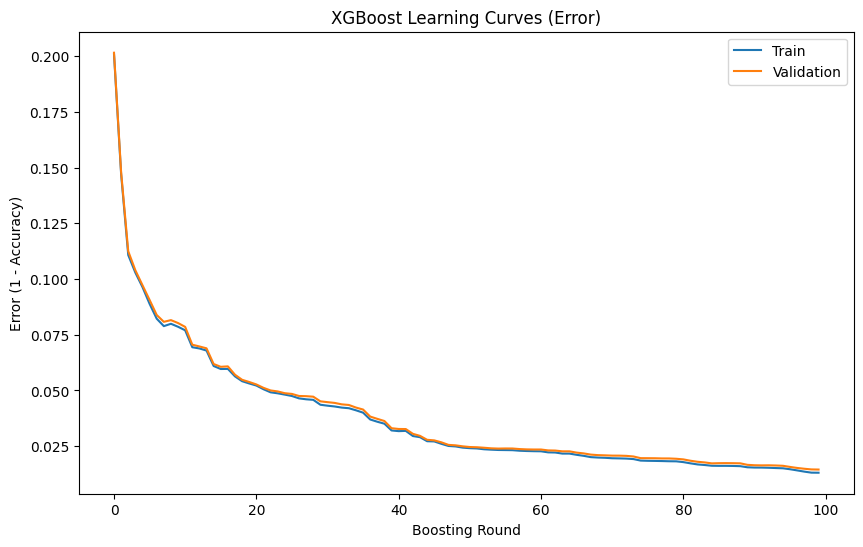

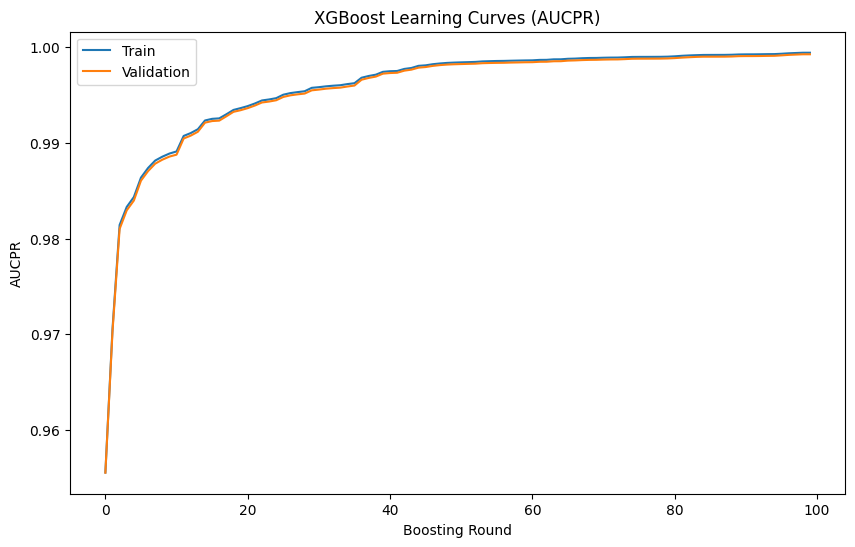

In [110]:
# Plotting the learning curves (training vs validation)
epochs = len(evals_result['train']['error'])
x_axis = range(0, epochs)

# Plot training and validation error (1 - accuracy)
plt.figure(figsize=(10, 6))
plt.plot(x_axis, evals_result['train']['error'], label='Train')
plt.plot(x_axis, evals_result['eval']['error'], label='Validation')
plt.xlabel('Boosting Round')
plt.ylabel('Error (1 - Accuracy)')
plt.title('XGBoost Learning Curves (Error)')
plt.legend()
plt.show()

# Plot training and validation aucpr
plt.figure(figsize=(10, 6))
plt.plot(x_axis, evals_result['train']['aucpr'], label='Train')
plt.plot(x_axis, evals_result['eval']['aucpr'], label='Validation')
plt.xlabel('Boosting Round')
plt.ylabel('AUCPR')
plt.title('XGBoost Learning Curves (AUCPR)')
plt.legend()
plt.show()


In [111]:
# Make predictions on the test data
y_pred_proba = bst.predict(dtest)  # Get predicted probabilities
y_pred = np.where(y_pred_proba > 0.5, 1, 0)  # Convert probabilities to binary predictions


Statistics:
True Negatives (TN): 38972
False Positives (FP): 718
False Negatives (FN): 982
True Positives (TP): 76811
Accuracy: 0.9855
Precision: 0.9907
Recall: 0.9874
F1 Score: 0.9891


<Figure size 800x600 with 0 Axes>

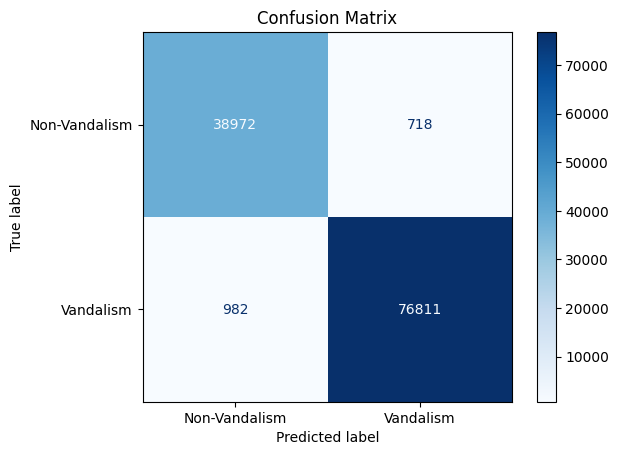

In [112]:
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Calculate additional statistics
TN, FP, FN, TP = cm.ravel()  # Unpack the confusion matrix
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print statistics
print(f"\nStatistics:")
print(f"True Negatives (TN): {TN}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")
print(f"True Positives (TP): {TP}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Vandalism', 'Vandalism']).plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()